# Analysis of distribution of shape statistics

This notebook uses indices capturing relationship between shape metrics and area of polygons across all FUAs, identifies peaks and valleys in the distribution using KDE and assesses performance of each shape metric in distinguishing between face polygons and face artifacts.

## Whole dataset

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

Set default plotting theme.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)


Generate KDE function for each FUA and each shape metric. Save number of peaks, number of valleys, their locations and probability density function.

In [4]:
results = {}
for option in [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]:
    kde_results = pandas.DataFrame(
        index=all_poly_data.name.unique(),
        columns=["n_peaks", "n_mins", "peaks", "mins", "pdf"],
    )

    for city in all_poly_data.name.unique():
        fua = all_poly_data[all_poly_data.name == city]

        # use log of the data
        data = numpy.log(fua[option])

        # generate Gaussian KDE
        kde = gaussian_kde(data, bw_method="silverman")

        # generate probability density function
        pdf = kde.pdf(numpy.linspace(data.min(), data.max(), 1000))

        # find peaks
        peaks = find_peaks(
            # ANA, WE NEED TO FIGURE OUT HOW TO SET PARAMETERS HERE, THIS IS TRIAL ERROR
            pdf,
            height=.02,
            threshold=None,
            distance=None,
            prominence=None,
            width=10,
            wlen=None,
            rel_height=0.5,
            plateau_size=None,
        )

        # find valleys based on inverse of PDF
        mins = find_peaks(
            # ANA, WE NEED TO FIGURE OUT HOW TO SET PARAMETERS HERE, THIS IS TRIAL ERROR
            -pdf + 1,
            height=(0, .99),
            threshold=None,
            distance=None,
            prominence=None,
            width=10,
            wlen=None,
            rel_height=0.5,
            plateau_size=(0, 10), 
        )

        kde_results.loc[city] = [len(peaks[0]), len(mins[0]), peaks[0], mins[0], pdf]

    kde_results["option"] = option
    results[option] = kde_results
    print(option)

results = pandas.concat(results, axis=0)

circular_compactness_index
isoperimetric_quotient_index
isoareal_quotient_index
radii_ratio_index
diameter_ratio_index


Assess whether an observation fulfils the condition of having a valley between two peaks.

In [5]:
r = []
for i, row in results.iterrows():
    if row.n_peaks > 1 and row.n_mins > 0:
        if (row.peaks[0] < row.mins[0]) and (row.peaks[1] > row.mins[0]):
            r.append(True)
        else:
            r.append(False)
    else:
        r.append(False)
results['min_btw_max'] = r

Measure a proportion of FUAs marked True.

<AxesSubplot: xlabel='option'>

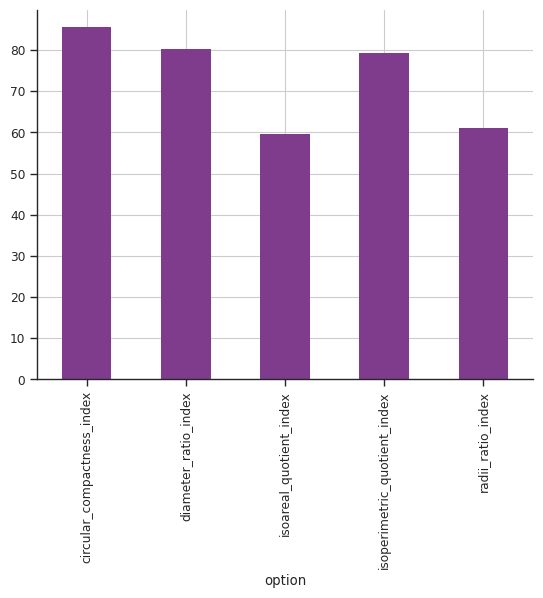

In [6]:
(results.groupby("option")["min_btw_max"].sum() / sample.shape[0] * 100).plot.bar()

Assess whether an observation fulfils the condition of having a valley between two peaks, given the strict approach when exactly 2 peaks and exactly 1 valley are found.

In [7]:
r = []
for i, row in results.iterrows():
    if row.n_peaks == 2 and row.n_mins == 1:
        if (row.peaks[0] < row.mins[0]) and (row.peaks[1] > row.mins[0]):
            r.append(True)
        else:
            r.append(False)
    else:
        r.append(False)
results['min_btw_max_strict'] = r

Measure a proportion of FUAs marked True.

<AxesSubplot: xlabel='option'>

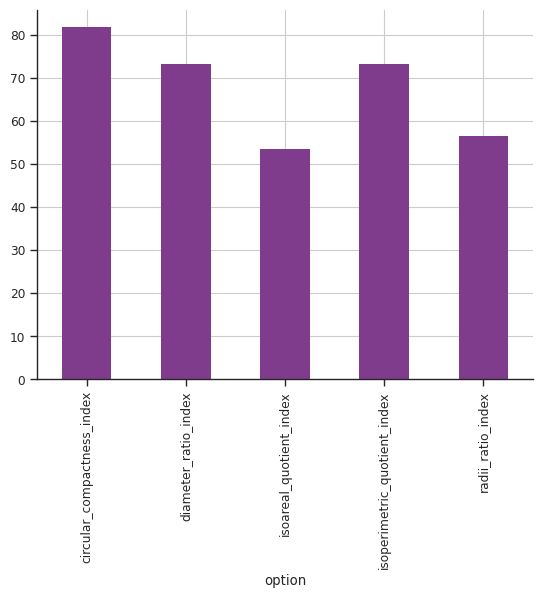

In [8]:
(results.groupby("option")["min_btw_max_strict"].sum() / sample.shape[0] * 100).plot.bar()

Measure the difference between the first peak and the first valley to capture the power of each shape metric.

In [9]:
r = []
for i, row in results.iterrows():
    if row.n_peaks > 1 and row.n_mins > 0:
        if (row.peaks[0] < row.mins[0]) and (row.peaks[1] > row.mins[0]):
            r.append(row.pdf[row.peaks[0]] - row.pdf[row.mins[0]])
        else:
            r.append(None)
    else:
        r.append(None)
results['difference'] = r

Measure mean by metric.

<AxesSubplot: xlabel='option'>

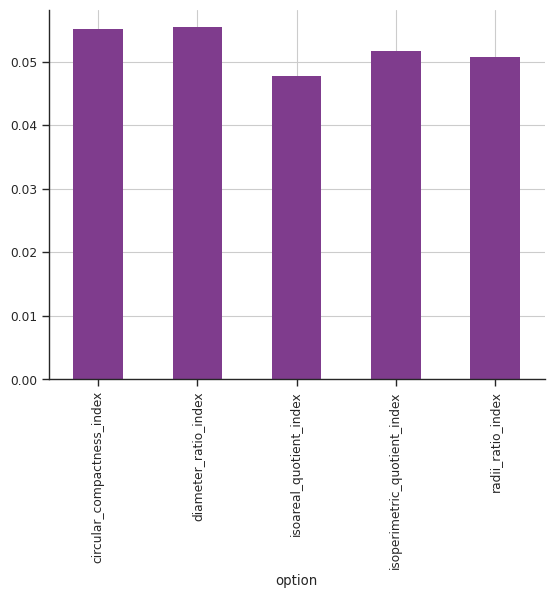

In [10]:
results.groupby("option")["difference"].mean().plot.bar()

In [11]:
results.to_csv("../results/peak_identification.csv")

## Identify peaks for single FUA

Code below replicates the process in the large for loop above.

<AxesSubplot: ylabel='Frequency'>

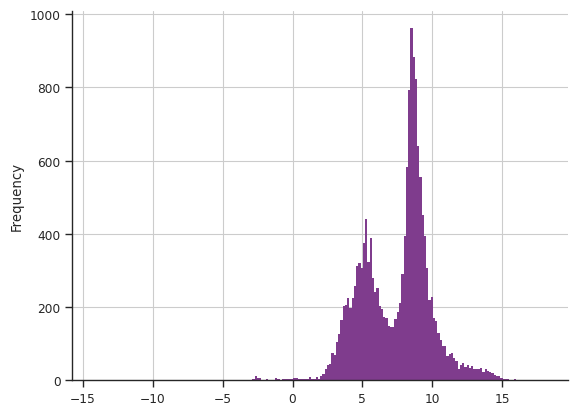

In [12]:
fua = all_poly_data[all_poly_data.name == "Glasgow"]

data = numpy.log(fua.circular_compactness_index)
data.plot.hist(bins=200)

Get KDE

In [13]:
kde = gaussian_kde(data, bw_method="silverman")
pdf = kde.pdf(numpy.linspace(data.min(), data.max(), 1000))


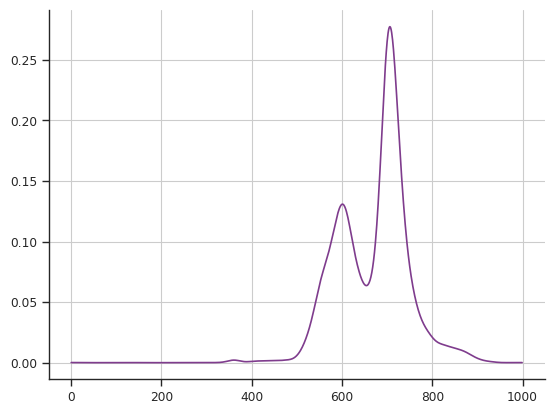

In [14]:
plt.plot(pdf)

Get peaks

In [15]:
peaks = find_peaks(
    pdf,
    height=.020,
    threshold=None,
    distance=None,
    prominence=None,
    width=10,
    wlen=None,
    rel_height=0.5,
    plateau_size=None,
)
peaks[0]

array([601, 706])

Get valleys

In [16]:
mins = find_peaks(
    -pdf + 1,
    height=(0, .99),
    threshold=None,
    distance=None,
    prominence=None,
    width=10,
    wlen=None,
    rel_height=0.5,
    plateau_size=(0, 10),
)
mins[0]


array([654])

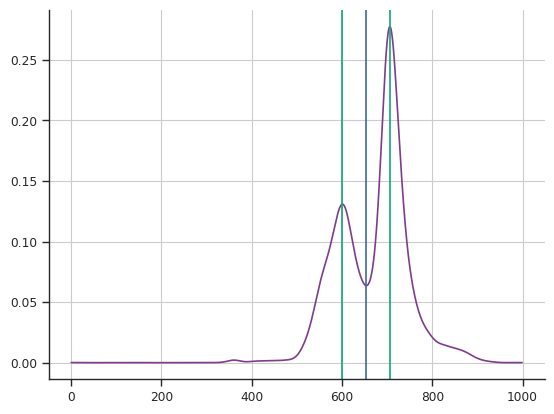

In [17]:
plt.plot(pdf)
for v in peaks[0]:
    plt.axvline(v, color=Bold_6.hex_colors[1])
for v in mins[0]:
    plt.axvline(v, color=Bold_6.hex_colors[2])